## Clasificador de Noticias Argentinas 

In [2]:
import pandas as pd

df = pd.read_excel('../../res/tp1/Noticias_argentinas.xlsx', sheet_name='aa_bayes')

In [3]:
# Nos quedamos con los atributos de interes

df = df[["titular", "categoria"]]

# removemos las categorias que no necesitamos ('Destacadas', 'Noticias Destacadas')


df.head()

,titular,categoria
0,Trabajadores del Buenos Aires Design cortan la...,Nacional
1,La boda del gobernador Gerardo Morales: tapas ...,Nacional
2,Cumbre del G20: qué calles estarán cortadas y ...,Nacional
3,Una fractura que confirma la candidatura de Cr...,Nacional
4,Infierno grande: ola de divorcios en un pueblo...,Nacional


In [4]:
df = df.loc[df['categoria'].isin(("Nacional", "Economia", "Internacional", "Deportes", "Salud", "Ciencia y Tecnologia", "Entretenimiento"))]
df.head()
categories = df['categoria'].unique()
print(categories)


['Nacional' 'Deportes' 'Salud' 'Ciencia y Tecnologia' 'Entretenimiento'
 'Economia' 'Internacional']


In [13]:
df['categoria'].value_counts()

Nacional                3860
Ciencia y Tecnologia    3856
Deportes                3855
Economia                3850
Internacional           3850
Entretenimiento         3850
Salud                   3840
Name: categoria, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)
train.head()
test.head()

,titular,categoria
18304,El científico chino aseguró que hay un segundo...,Salud
14494,Los gremios del transporte ratificaron el paro...,Nacional
8815,Procesan a Dilma ya Lula por supuesta asociaci...,Internacional
26450,El nuevo gaffe de Samsung: promocionó al Galax...,Ciencia y Tecnologia
16718,"Viral: ""Knickers"", el buey que fascina a mucho...",Internacional


In [15]:
textos = list(df['titular'])

In [16]:
# Crear diccionario de categorias con diccionarios vacios para las palabras de los titulares
categories_word_appearances = { i : {} for i in categories }

In [17]:
import re

def split_and_sanitize(title):
    words = title.split()  # se separan las palabras según espacios (quita todos los espacios)
    words = list(map(lambda x: re.sub("[^\w\s]", '', x), words))  # reemplazo de símbolos por ningún caracter
    return words

for i in range(len(train)):
    row = train.iloc[i]
    category = row['categoria']
    title = row['titular']
    words = split_and_sanitize(title)
    
    for word in words:
            if word in categories_word_appearances[category]:
                categories_word_appearances[category][word] += 1
            else:
                categories_word_appearances[category][word] = 1
                
    
    
    

In [18]:
print(categories_word_appearances['Entretenimiento']['Pampita'])

71


In [73]:
# Calcular probabilidades de las clases P(category) para el conjunto de entrenamiento

category_relative_freq = train['categoria'].value_counts() / len(train)  # P(category)
print(category_relative_freq)

# Calcular las probabilidades condicionales P(word | category)
word_relative_frequencies = { i : {} for i in categories }
zero_probabilities = { i : 0 for i in categories } # Laplace correction in case a word does not appear in a category
for category in categories:
    word_appearances_sum = sum(categories_word_appearances[category].values())
    laplace_denominator = float(word_appearances_sum + len(categories_word_appearances[category].keys()))
    zero_probabilities[category] = 1 / laplace_denominator
    for word, word_count in categories_word_appearances[category].items():
        word_relative_frequencies[category][word] = (word_count + 1) / laplace_denominator

print(word_relative_frequencies['Entretenimiento']['Pampita'])
print(sum(word_relative_frequencies['Entretenimiento'].values()))
# Objetivo final:
#   P (category | [word])
# = P ([word] | category) * P (category)      ##  / P ([word])
# = prod(P (word | category)) * P (category)

Nacional                0.144334
Entretenimiento         0.143639
Deportes                0.143500
Ciencia y Tecnologia    0.143268
Internacional           0.143129
Economia                0.142201
Salud                   0.139930
Name: categoria, dtype: float64
0.0015288571792585043
1.000000000000055


In [74]:
def classify(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]
            else:
                v *= zero_probabilities[category]
        vs[category] = v
        print(v)
    mx = (None, 0)
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
    return mx[0]

noticia = 'Pampita fue a la mesa de Mirtha'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Messi metió un gol'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Apple lanzó un nuevo iPhone'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")

4.1670543700484208e-22
7.348490101725316e-22
1.340809480879573e-22
2.708525210714131e-23
2.253064230566973e-17
2.208056340719943e-23
6.823941902427105e-22
La noticia 'Pampita fue a la mesa de Mirtha' pertenece a Entretenimiento
2.0830200162616676e-16
4.2527363597367465e-13
3.4645868813205315e-17
2.449897394161073e-17
3.0066145484145796e-16
1.369356882527115e-16
1.0520004921102889e-16
La noticia 'Messi metió un gol' pertenece a Deportes
2.6570488497648702e-20
2.4606516891915228e-20
9.816282752871257e-20
1.5102735563862537e-14
1.377941224004785e-19
2.60397178740888e-18
1.3713030658637435e-18
La noticia 'Apple lanzó un nuevo iPhone' pertenece a Ciencia y Tecnologia


<AxesSubplot:>

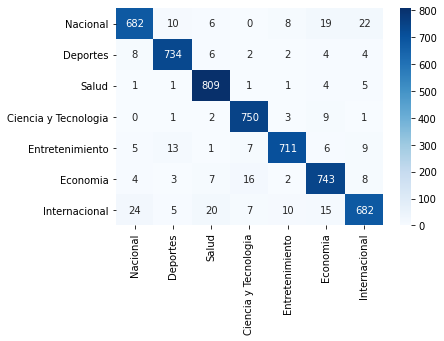

In [21]:
confusion_matrix = { i : {} for i in categories }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { i : 0 for i in categories } # {'Deportes': {'Deportes': 700, 'Entretenimiento': 3, ...}, ...}

for i in range(len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    result = classify(title)
    confusion_matrix[category][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

import seaborn as sns
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [23]:
import numpy as np

true = []
predicted = []

for i in range(len(test)):
    row = test.iloc[i]
    true.append(row['categoria'])
    title = row['titular']
    predicted.append(classify(title))

    
# Calculamos las metricas para cada categoria    
    
category_metrics = { i : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0,  'f1': 0} for i in categories }

for i, category in enumerate(categories):
    
    # Metricas simples
    tp = confusion_df.iloc[i,i]
    tn = sum(np.diag(confusion_df)) - tp
    fn = sum(confusion_df.loc[category]) - tp
    fp = sum(confusion_df[category]) - tp
    
    category_metrics[category]['tp'] = tp
    category_metrics[category]['tn'] = tn
    category_metrics[category]['fp'] = fp
    category_metrics[category]['fn'] = fn
    
    # Metricas compuestas
    category_metrics[category]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
    category_metrics[category]['precision'] = tp / (tp + fp)
    category_metrics[category]['recall'] = tp / (tp + fn)
    category_metrics[category]['f1'] = (2 * category_metrics[category]['precision'] * category_metrics[category]['recall']) / (category_metrics[category]['precision'] + category_metrics[category]['recall'])

metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = { key : list(category_metrics[key].values()) for key in category_metrics.keys() }    
metrics_df = pd.DataFrame.from_dict(category_metrics, orient='index', columns=metric_cols)
metrics_df.head()

# Calculamos las metricas para el classifier en general (checkear cual es la forma correcta)
    
tp, fp, fn = 0, 0, 0


for i, category in enumerate(categories):
    tp += confusion_df.iloc[i, i]
    fp += sum(confusion_df.iloc[i, :i])
    fn += sum(confusion_df.iloc[i, i+1:])
    
tn = confusion_df.to_numpy().sum() - (fp + fn + tp)

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

metrics_df

    



,tp,tn,fp,fn,accuracy,precision,recall,f1
Nacional,682,4429,42,65,0.979494,0.941989,0.912985,0.927260
Deportes,734,4377,33,26,0.988588,0.956975,0.965789,0.961362
Salud,809,4302,42,13,0.989353,0.950646,0.984185,0.967125
Ciencia y Tecnologia,750,4361,33,16,0.990504,0.957854,0.979112,0.968367
Entretenimiento,711,4400,26,41,0.987061,0.964722,0.945479,0.955003
Economia,743,4368,57,40,0.981375,0.928750,0.948914,0.938724
Internacional,682,4429,49,81,0.975196,0.932969,0.893840,0.912985


In [33]:
# Calcular cantidad total de apariciones de palabras
totalCount = 0
uniqueWords = set({})
for category in categories:
    for key in categories_word_appearances[category].keys():
        totalCount += categories_word_appearances[category][key]
        uniqueWords.add(key)
        
print(totalCount)
print(len(uniqueWords))

273553
14342


In [94]:
# Calcular curva ROC
            
def calc_word_prob(word): # P(word)
    wordCount = 0
    
    for category in categories:
        if word in categories_word_appearances[category]:
            wordCount += categories_word_appearances[category][word]
            
    # print(f"wordCount / float(totalCount): {wordCount / float(totalCount)}")  
    return (wordCount + 1) / float(totalCount + len(uniqueWords))
    
    

def classify_with_prob(title):
    words = split_and_sanitize(title)
    
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        word_prob = 0 #calc_word_prob(word)
        for word in words:
            # word count / total de apariciones de todas las palabras
            
            for c in categories:
                word_prob += (word_relative_frequencies[c][word] if word in word_relative_frequencies[c] else zero_probabilities[c]) * category_relative_freq.loc[c]
            
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]# / word_prob
                #print(f"{category}: {word}: {word_relative_frequencies[category][word]} {word_relative_frequencies[category][word] / word_prob}")
            else:
                v *= zero_probabilities[category]# / word_prob
                #print(f"{category}: {word}: {zero_probabilities[category]} {zero_probabilities[category] / word_prob}")
        vs[category] = v / word_prob
    print(vs)
    mx = (None, 0)
    tot = 0
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
        tot += v
    print(tot)
    return mx

In [66]:
x = 0
for word in uniqueWords:
    x += calc_word_prob(word)
print(x)

0.9999999999999131


In [95]:
classify_with_prob("Apple lanzó un nuevo iPhone")

{'Nacional': 1.774698610117708e-18, 'Deportes': 1.643520830706002e-18, 'Salud': 6.55650096895459e-18, 'Ciencia y Tecnologia': 1.0087433588785537e-12, 'Entretenimiento': 9.203558208128497e-18, 'Economia': 1.7392473278423966e-16, 'Internacional': 9.159220558755998e-17}
1.0090280540955434e-12


('Ciencia y Tecnologia', 1.0087433588785537e-12)

In [84]:
classification_probs = []
u = [0.1 * x for x in range(1, 10)]

for j in u:
    for i in range(10):#len(test)): # calcular tasa / con umbral j
        row = test.iloc[i]
        category = row['categoria']
        title = row['titular']
        cat, prob = classify_with_prob(title)
        #print(cat)
        #print(prob)
        classification_probs.append(classify_with_prob(title))
    # graficar punto

#print(classification_probs)

Salud
37688.6124619906
Nacional
2197.652737064786
Internacional
7269.70294666329
Ciencia y Tecnologia
119388.04337542111
Internacional
604.9478761794767
Internacional
13528.257558707615
Entretenimiento
6.499396699461685
Ciencia y Tecnologia
8149.448503117781
Deportes
9829.03866405017
Salud
71.78521647311898
Salud
37688.6124619906
Nacional
2197.652737064786
Internacional
7269.70294666329
Ciencia y Tecnologia
119388.04337542111
Internacional
604.9478761794767
Internacional
13528.257558707615
Entretenimiento
6.499396699461685
Ciencia y Tecnologia
8149.448503117781
Deportes
9829.03866405017
Salud
71.78521647311898
Salud
37688.6124619906
Nacional
2197.652737064786
Internacional
7269.70294666329
Ciencia y Tecnologia
119388.04337542111
Internacional
604.9478761794767
Internacional
13528.257558707615
Entretenimiento
6.499396699461685
Ciencia y Tecnologia
8149.448503117781
Deportes
9829.03866405017
Salud
71.78521647311898
Salud
37688.6124619906
Nacional
2197.652737064786
Internacional
7269.7029